# Del 9: Decision Trees and Random Forests

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Introduction to Decision Trees

<img src="https://jakevdp.github.io//PythonDataScienceHandbook/figures/05.08-decision-tree.png" alt="">

### Overview of the Data Set

In [2]:
income = pd.read_csv("data/income.csv", index_col=False)
income.head(5)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
income.shape

(32561, 15)

In [4]:
income['high_income'].value_counts()

 <=50K    24720
 >50K      7841
Name: high_income, dtype: int64

### Converting Categorical Variables

In [5]:
cat_columns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country", "high_income"]

for name in cat_columns:
    col = pd.Categorical(income[name])
    income[name] = col.codes

In [6]:
income.head(3)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0


### Splitting Data

In [7]:
private_incomes = income[income["workclass"] == 4]
public_incomes = income[income["workclass"] != 4]

print(private_incomes.shape)
print(public_incomes.shape)

(22696, 15)
(9865, 15)


### Overview of Data Set Entropy

$-\sum_{i=1}^{c} {\mathrm{P}(x_i) \log_b \mathrm{P}(x_i)}$

In [8]:
import math


prob_0 = income[income["high_income"] == 0].shape[0] / income.shape[0]
prob_1 = income[income["high_income"] == 1].shape[0] / income.shape[0]

income_entropy = -(prob_0 * math.log(prob_0, 2) + prob_1 * math.log(prob_1, 2))

In [9]:
income_entropy

0.7963839552022132

### Information Gain

$IG(T,A) = Entropy(T)-\sum_{v\in A}\frac{|T_{v}|}{|T|} \cdot Entropy(T_{v})$

In [10]:
import numpy as np

def calc_entropy(column):
    """
    Calculate entropy given a pandas series, list, or numpy array.
    """
    # Compute the counts of each unique value in the column
    counts = np.bincount(column)
    # Divide by the total column length to get a probability
    probabilities = counts / len(column)
    
    # Initialize the entropy to 0
    entropy = 0
    # Loop through the probabilities, and add each one to the total entropy
    for prob in probabilities:
        if prob > 0:
            entropy += prob * math.log(prob, 2)
    
    return -entropy

In [11]:
income_entropy = calc_entropy(income["high_income"])
income_entropy

0.7963839552022132

In [12]:
# Razdelimo starost na dve kategorijji
median_age = income["age"].median()

left_split = income[income["age"] <= median_age]
right_split = income[income["age"] > median_age]

In [13]:
age_information_gain = income_entropy - ((left_split.shape[0] / income.shape[0]) * calc_entropy(left_split["high_income"]) 
                    + ((right_split.shape[0] / income.shape[0]) * calc_entropy(right_split["high_income"])))

In [14]:
age_information_gain

0.047028661304691965

### Finding the Best Split

In [15]:
def calc_information_gain(data, split_name, target_name):
    """
    Calculate information gain given a data set, column to split on, and target
    """
    # Calculate the original entropy
    original_entropy = calc_entropy(data[target_name])
    
    # Find the median of the column we're splitting
    column = data[split_name]
    median = column.median()
    
    # Make two subsets of the data, based on the median
    left_split = data[column <= median]
    right_split = data[column > median]
    
    # Loop through the splits and calculate the subset entropies
    to_subtract = 0
    for subset in [left_split, right_split]:
        prob = (subset.shape[0] / data.shape[0]) 
        to_subtract += prob * calc_entropy(subset[target_name])
    
    # Return information gain
    return original_entropy - to_subtract

In [16]:
columns = ["age", "workclass", "education_num", "marital_status", "occupation", "relationship", 
           "race", "sex", "hours_per_week", "native_country"]

In [17]:
information_gains = []
for col in columns:
    information_gain = calc_information_gain(income, col, "high_income")
    information_gains.append(information_gain)

In [18]:
highest_gain_index = information_gains.index(max(information_gains))
highest_gain = columns[highest_gain_index]
highest_gain

'marital_status'

## Prikaz delovanja: Decision Trees

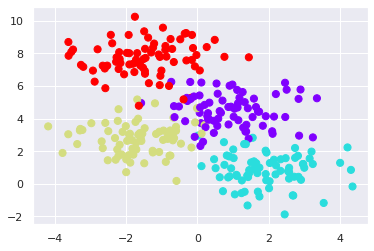

In [19]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')
plt.show()

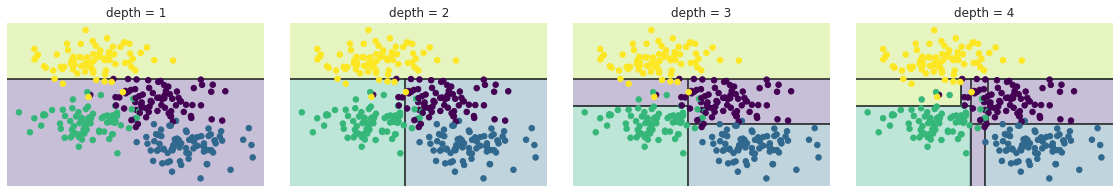

In [20]:
from helpers import visualize_tree
from sklearn.tree import DecisionTreeClassifier
        
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)

for axi, depth in zip(ax, range(1, 5)):
    model = DecisionTreeClassifier(max_depth=depth)
    visualize_tree(model, X, y, ax=axi)
    axi.set_title('depth = {0}'.format(depth))

plt.show()

In [21]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

In [22]:
from helpers import visualize_classifier

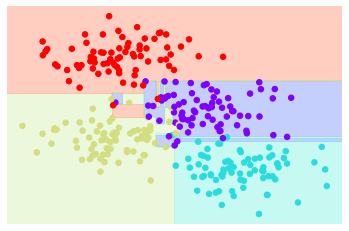

In [23]:
visualize_classifier(DecisionTreeClassifier(), X, y)

In [24]:
from helpers import plot_tree_interactive

In [25]:
plot_tree_interactive(X, y)
plt.show()

interactive(children=(Dropdown(description='depth', options=(1, 2, 3, 4, 5, 6), value=1), Output()), _dom_clas…

## Applying Decision Trees

### Using Decision Trees With scikit-learn

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [27]:
columns = ["age", "workclass", "education_num", "marital_status", "occupation", "relationship", "race", 
           "sex", "hours_per_week", "native_country"]

In [28]:
X = income[columns]
y = income["high_income"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [29]:
clf = DecisionTreeClassifier(random_state=1)

In [30]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [31]:
print(f"Accuracy on training set: {clf.score(X_train, y_train):.3f}")

Accuracy on training set: 0.971


In [32]:
print(f"Accuracy on test set: {clf.score(X_test, y_test):.3f}")

Accuracy on test set: 0.780


### Evaluating Error With AUC

In [33]:
from sklearn.metrics import roc_auc_score

In [34]:
predictions = clf.predict(X_test)

In [35]:
error = roc_auc_score(y_test, predictions)
print(error)

0.6914286647803386


In [36]:
predictions = clf.predict(X_train)
print(roc_auc_score(y_train, predictions))

0.9492852808738997


### Decision Tree Overfitting

### Combat overfitting: Restrict the depth of the tree

- `max_depth`: Globally restricts how deep the tree can go
- `min_samples_split`: The minimum number of rows a node should have before it can be split; if this is set to 2, for example, then nodes with 2 rows won't be split, and will become leaves instead

In [38]:
from sklearn.model_selection import GridSearchCV

In [39]:
clf = DecisionTreeClassifier(random_state=1)

In [40]:
param_grid = {'min_samples_split': list(range(2,15))}

grid = GridSearchCV(clf, param_grid)

grid.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14]})

In [41]:
print(grid.best_params_)

{'min_samples_split': 14}


In [42]:
# ponovimo oceno z najboljšim parametrom
clf = DecisionTreeClassifier(min_samples_split=14, random_state=1)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
test_auc = roc_auc_score(y_test, predictions)

train_predictions = clf.predict(X_train)
train_auc = roc_auc_score(y_train, train_predictions)

print('Test:', test_auc)
print('Train:',train_auc)

Test: 0.7080228842522104
Train: 0.8432201670778869


In [43]:
clf = DecisionTreeClassifier(random_state=1, min_samples_split=14)

param_grid = {'max_depth': list(range(2,12))}

grid = GridSearchCV(clf, param_grid)

grid.fit(X_train, y_train)

print(grid.best_params_)

{'max_depth': 7}


In [44]:
# ponovimo oceno z najboljšim parametrom
clf = DecisionTreeClassifier(min_samples_split=14, max_depth=7, random_state=1)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
test_auc = roc_auc_score(y_test, predictions)

train_predictions = clf.predict(X_train)
train_auc = roc_auc_score(y_train, train_predictions)

print('Test:', test_auc)
print('Train:',train_auc)

Test: 0.7298545392763558
Train: 0.7497841369255565


In [45]:
# VAJA: Grid search z dvemi parametri
clf = DecisionTreeClassifier(random_state=1)

param_grid = {'max_depth': list(range(2,12)), 
              'min_samples_split': list(range(2,15))}

grid = GridSearchCV(clf, param_grid)

grid.fit(X_train, y_train)

print(grid.best_params_)

{'max_depth': 7, 'min_samples_split': 14}


In [46]:
# prikažemo underfitting
clf = DecisionTreeClassifier(min_samples_split=100, max_depth=2, random_state=1)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
test_auc = roc_auc_score(y_test, predictions)

train_predictions = clf.predict(X_train)
train_auc = roc_auc_score(y_train, train_predictions)

print('Test:', test_auc)
print('Train:',train_auc)

Test: 0.6490507152145644
Train: 0.6638378859251265


In [47]:
# priverjava test/train score za različne globine drevesa

max_depths = list(range(1,25))

test_aucs = []
train_aucs = []

for max_depth in max_depths:
    clf = DecisionTreeClassifier(min_samples_split=14, max_depth=max_depth, random_state=1)
    clf.fit(X_train, y_train)

    test_predictions = clf.predict(X_test)
    test_auc = roc_auc_score(y_test, test_predictions)
    test_aucs.append(test_auc)

    train_predictions = clf.predict(X_train)
    train_auc = roc_auc_score(y_train, train_predictions)
    train_aucs.append(train_auc)

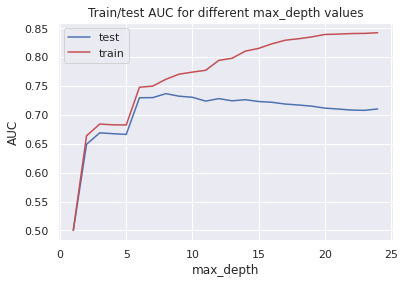

In [48]:
plt.plot(max_depths, test_aucs, label='test')
plt.plot(max_depths, train_aucs, c='r', label='train')
plt.legend()
plt.title('Train/test AUC for different max_depth values')
plt.xlabel('max_depth')
plt.ylabel('AUC')
plt.show()

#### The Bias-Variance Tradeoff

### Analyzing decision trees

In [50]:
#!pip install graphviz

In [57]:
clf = DecisionTreeClassifier(max_depth=2, random_state=1)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=1)

In [58]:
from sklearn.tree import export_graphviz

export_graphviz(clf, 
                out_file="data/tree.dot", 
                class_names=["<=50K", ">50K"],
                feature_names=columns,
                impurity=False, 
                filled=True)

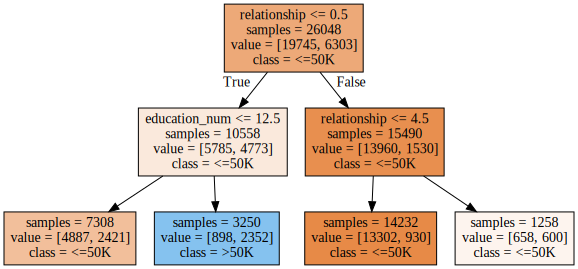

In [59]:
import graphviz

with open("data/tree.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph)

### Feature importance in trees

In [60]:
clf = DecisionTreeClassifier(max_depth=4, random_state=1)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=1)

In [61]:
clf.feature_importances_

array([0.05941802, 0.        , 0.30892634, 0.        , 0.00441665,
       0.60159758, 0.        , 0.        , 0.02564141, 0.        ])

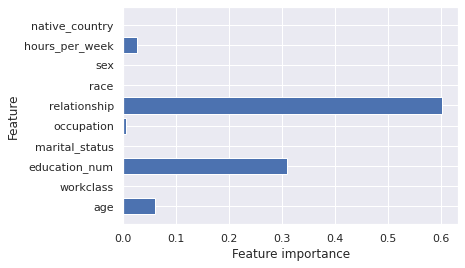

In [62]:
n_features = len(columns)
plt.barh(range(n_features), clf.feature_importances_, align='center')
plt.yticks(np.arange(n_features), columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

### Knowing When to Use Decision Trees

Prednosti:
- Easy to interpret
- Relatively fast to fit and make predictions
- Able to handle multiple types of data
- Able to pick up nonlinearities in data, and usually fairly accurate
- the algorithms are completely invariant to scaling of the data

### Prikaz delovanja: Decision trees and over-fitting

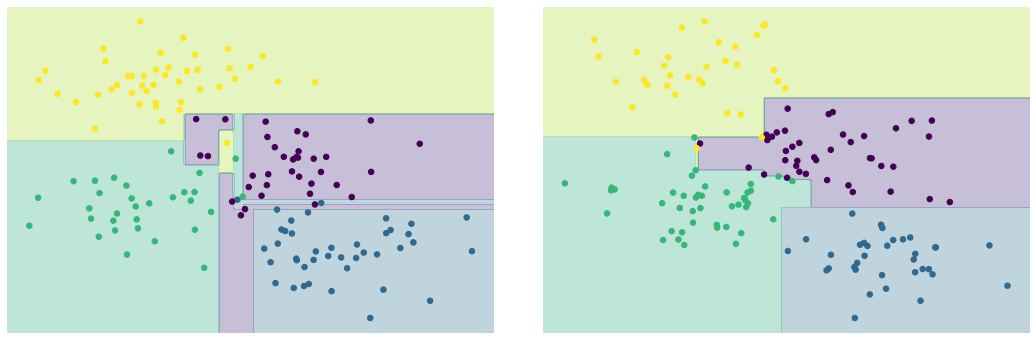

In [63]:
from sklearn.datasets import make_blobs
from helpers import visualize_tree

model = DecisionTreeClassifier()

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
visualize_tree(model, X[::2], y[::2], boundaries=False, ax=ax[0])
visualize_tree(model, X[1::2], y[1::2], boundaries=False, ax=ax[1])
plt.show()

In [64]:
import helpers

helpers.randomized_tree_interactive(X, y)
plt.show()

interactive(children=(Dropdown(description='random_state', options=(0, 25, 50, 75, 100), value=0), Output()), …

## Introduction to Random Forests

### Combining Model Predictions With Ensembles

In [65]:
columns = ["age", "workclass", "education_num", "marital_status", "occupation", "relationship", 
           "race", "sex", "hours_per_week", "native_country"]

In [66]:
X = income[columns]
y = income["high_income"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [67]:
clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=2)
clf.fit(X_train, y_train)

clf2 = DecisionTreeClassifier(random_state=1, max_depth=5)
clf2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=1)

In [68]:
predictions = clf.predict(X_test)
print(roc_auc_score(y_test, predictions))

0.692814570654093


In [69]:
predictions = clf2.predict(X_test)
print(roc_auc_score(y_test, predictions))

0.6905489894688739


In [72]:
predictions = clf.predict_proba(X_test[columns])[:,1]
predictions2 = clf2.predict_proba(X_test[columns])[:,1]
combined = (predictions + predictions2) / 2
rounded = np.round(combined)

print(roc_auc_score(y_test, rounded))

0.7202262660199821


### Introducing Variation With Bagging

In [73]:
tree_count = 10

bag_proportion = .6

In [74]:
np.random.seed(1)
income = income.reindex(np.random.permutation(income.index))
train_max_row = math.floor(income.shape[0] * .8)
train = income.iloc[:train_max_row]
test = income.iloc[train_max_row:]

In [75]:
predictions = []
for i in range(tree_count):
    bag = train.sample(frac=bag_proportion, replace=True, random_state=i)
    
    clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=2)
    clf.fit(bag[columns], bag["high_income"])
    
    predictions.append(clf.predict_proba(test[columns])[:,1])
    
combined = np.sum(predictions, axis=0) / 10
rounded = np.round(combined)

print(roc_auc_score(test["high_income"], rounded))

0.7329963297474371


### Selecting Random Features

In [76]:
predictions = []

for i in range(tree_count):
    bag = train.sample(frac=bag_proportion, replace=True, random_state=i)
    
    clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=2, splitter="random", max_features="auto")
    clf.fit(bag[columns], bag["high_income"])
    
    predictions.append(clf.predict_proba(test[columns])[:,1])

combined = np.sum(predictions, axis=0) / 10
rounded = np.round(combined)

print(roc_auc_score(test["high_income"], rounded))

0.7345958637997538


### Prikaz delovanja: Random Forests

In [77]:
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

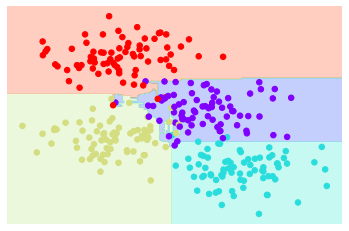

In [78]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)
plt.show()

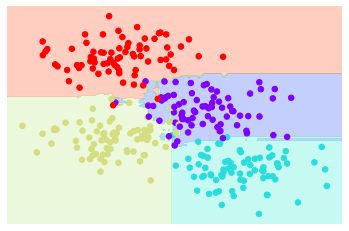

In [79]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

### Using RandomForestClassifier 

In [80]:
X = income[columns]
y = income["high_income"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

clf = RandomForestClassifier(n_estimators=5, random_state=1, min_samples_leaf=2)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print(roc_auc_score(y_test, predictions))

0.7414892775879184


In [82]:
print(f"Accuracy on training set: {clf.score(X_train, y_train):.3f}")
print(f"Accuracy on test set: {clf.score(X_test, y_test):.3f}")

Accuracy on training set: 0.894
Accuracy on test set: 0.833


In [83]:
importances = pd.Series(data=clf.feature_importances_, index= X_train.columns)

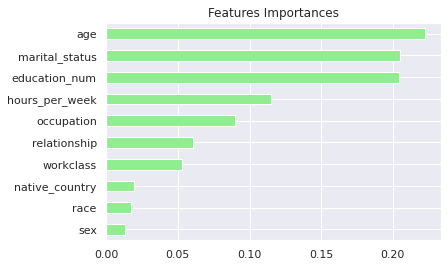

In [84]:
importances_sorted = importances.sort_values()

importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

### Tweaking Parameters to Increase Accuracy

- min_samples_leaf
- min_samples_split
- max_depth
- max_leaf_nodes

- n_estimators

In [88]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150, random_state=1, min_samples_leaf=2)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print(roc_auc_score(y_test, predictions))

0.7551018470237859
CPU times: user 4.46 s, sys: 0 ns, total: 4.46 s
Wall time: 4.46 s


In [87]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150, random_state=5, min_samples_leaf=2, n_jobs=-1)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print(roc_auc_score(y_test, predictions))

0.7575417597086187
CPU times: user 7.26 s, sys: 625 ms, total: 7.89 s
Wall time: 2.38 s


### Reducing Overfitting

### Summary of Random Forests

## Example: Random Forest for Classifying Digits

In [89]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

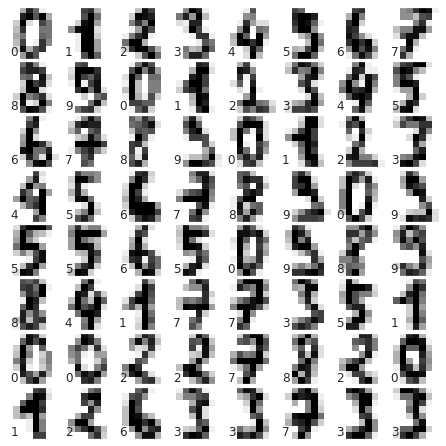

In [90]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))
plt.show()

In [91]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)

model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [92]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.95      0.97        44
           2       0.95      1.00      0.98        42
           3       0.98      0.98      0.98        45
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



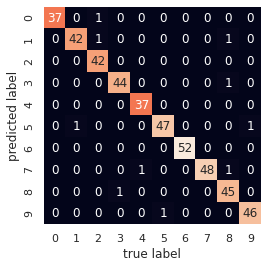

In [93]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)

plt.xlabel('true label')
plt.ylabel('predicted label');

## Gradient boosted regression trees (gradient boosting machines)

In [94]:
columns = ["age", "workclass", "education_num", "marital_status", "occupation", "relationship", 
           "race", "sex", "hours_per_week", "native_country"]

X = income[columns]
y = income["high_income"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [95]:
from sklearn.ensemble import GradientBoostingClassifier

In [96]:
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [97]:
print(f"Accuracy on training set: {gbrt.score(X_train, y_train):.3f}")
print(f"Accuracy on test set: {gbrt.score(X_test, y_test):.3f}")

Accuracy on training set: 0.845
Accuracy on test set: 0.843


In [98]:
gbrt = GradientBoostingClassifier(random_state=0)

param_grid = {'max_depth': list(range(1,7)), 'learning_rate': [0.001, 0.025, 0.01, 0.1, 0.5]}

grid = GridSearchCV(gbrt, param_grid, n_jobs=-1, verbose=1)

grid.fit(X_train, y_train)

print(grid.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.4min finished


{'learning_rate': 0.5, 'max_depth': 2}


In [99]:
best_model = grid.best_estimator_

In [100]:
print(f"Accuracy on training set: {best_model.score(X_train, y_train):.3f}")
print(f"Accuracy on test set: {best_model.score(X_test, y_test):.3f}")

Accuracy on training set: 0.848
Accuracy on test set: 0.842


In [101]:
n_estimators_list = list(range(100,1100,100))

test_aucs = []
train_aucs = []
test_accuracy = []
train_accuracy = []

for n_estimators in n_estimators_list:
    clf = GradientBoostingClassifier(max_depth=5, n_estimators=n_estimators, random_state=0)
    clf.fit(X_train, y_train)

    # Test data
    test_predictions = clf.predict(X_test)
    test_auc = roc_auc_score(y_test, test_predictions)
    test_aucs.append(test_auc)
    
    test_acc = clf.score(X_test, y_test)
    test_accuracy.append(test_acc)
    
    # Train data
    train_predictions = clf.predict(X_train)
    train_auc = roc_auc_score(y_train, train_predictions)
    train_aucs.append(train_auc)
    
    train_acc = clf.score(X_train, y_train)
    train_accuracy.append(train_acc)

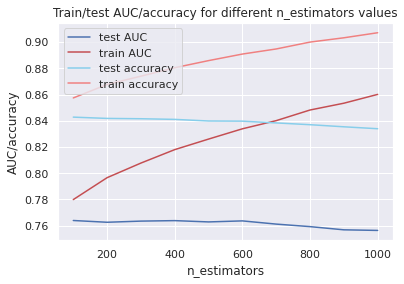

In [102]:
plt.plot(n_estimators_list, test_aucs, c='b', label='test AUC')
plt.plot(n_estimators_list, train_aucs, c='r', label='train AUC')

plt.plot(n_estimators_list, test_accuracy, c='skyblue', label='test accuracy')
plt.plot(n_estimators_list, train_accuracy, c='lightcoral', label='train accuracy')

plt.legend()
plt.title('Train/test AUC/accuracy for different n_estimators values')
plt.xlabel('n_estimators')
plt.ylabel('AUC/accuracy')
plt.show()

In [103]:
# priverjava test/train score za različne globine drevesa

max_depths = list(range(1,10))

test_aucs = []
train_aucs = []
test_accuracy = []
train_accuracy = []

for max_depth in max_depths:
    clf = GradientBoostingClassifier(max_depth=max_depth, random_state=0)
    clf.fit(X_train, y_train)

    # Test data
    test_predictions = clf.predict(X_test)
    test_auc = roc_auc_score(y_test, test_predictions)
    test_aucs.append(test_auc)
    
    test_acc = clf.score(X_test, y_test)
    test_accuracy.append(test_acc)
    
    # Train data
    train_predictions = clf.predict(X_train)
    train_auc = roc_auc_score(y_train, train_predictions)
    train_aucs.append(train_auc)
    
    train_acc = clf.score(X_train, y_train)
    train_accuracy.append(train_acc)

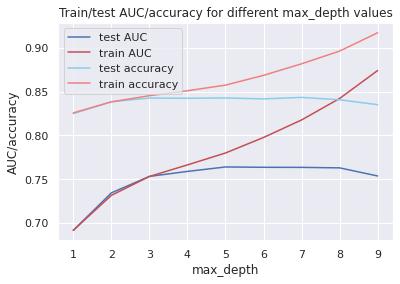

In [104]:
plt.plot(max_depths, test_aucs, c='b', label='test AUC')
plt.plot(max_depths, train_aucs, c='r', label='train AUC')

plt.plot(max_depths, test_accuracy, c='skyblue', label='test accuracy')
plt.plot(max_depths, train_accuracy, c='lightcoral', label='train accuracy')

plt.legend()
plt.title('Train/test AUC/accuracy for different max_depth values')
plt.xlabel('max_depth')
plt.ylabel('AUC/accuracy')
plt.show()

In [105]:
# priverjava test/train score za različne learning_rate pri max_depth = 5

learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

test_aucs = []
train_aucs = []
test_accuracy = []
train_accuracy = []

for learning_rate in learning_rates:
    clf = GradientBoostingClassifier(max_depth=5, learning_rate=learning_rate, random_state=0)
    clf.fit(X_train, y_train)

    # Test data
    test_predictions = clf.predict(X_test)
    test_auc = roc_auc_score(y_test, test_predictions)
    test_aucs.append(test_auc)
    
    test_acc = clf.score(X_test, y_test)
    test_accuracy.append(test_acc)
    
    # Train data
    train_predictions = clf.predict(X_train)
    train_auc = roc_auc_score(y_train, train_predictions)
    train_aucs.append(train_auc)
    
    train_acc = clf.score(X_train, y_train)
    train_accuracy.append(train_acc)

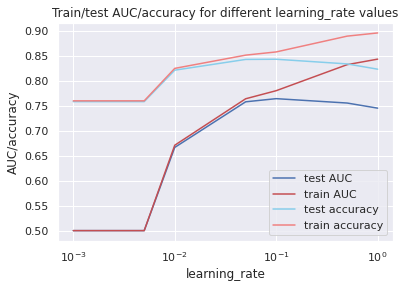

In [106]:
plt.plot(learning_rates, test_aucs, c='b', label='test AUC')
plt.plot(learning_rates, train_aucs, c='r', label='train AUC')

plt.plot(learning_rates, test_accuracy, c='skyblue', label='test accuracy')
plt.plot(learning_rates, train_accuracy, c='lightcoral', label='train accuracy')

plt.legend()
plt.title('Train/test AUC/accuracy for different learning_rate values')
plt.xlabel('learning_rate')
plt.ylabel('AUC/accuracy')
plt.xscale('log')
plt.show()